# Probability and Linearity in Data

Import necessary libraries in Python: 

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import linalg
from scipy import stats
from IPython.display import HTML, display

plt.rcdefaults()
# plt.xkcd(scale=1, length=300, randomness=5)

## A. Probabilities in Language

Let's look at a collection of emails, with spams and hams: 
https://www.kaggle.com/uciml/sms-spam-collection-dataset

Here is a local copy of the data: [spam.csv](data/spam.csv). 

### A.1. Load Data

In [2]:
emails = pd.read_csv("data/spam.csv", encoding="iso8859-1")
emails[['v1','v2']].head()

v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

### A.2. Zipf's Law

Let's tokenize the emails and count word frequencies.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a count vectorizer
vect = CountVectorizer(analyzer="word")
# obtain vocabulary dictionary and return doc-term matrix
X = vect.fit_transform(emails.v2) 
# get the identified terms
terms = vect.get_feature_names()
# sum terms' frequencies in the entire collection
freqs = X.toarray().sum(axis=0)
terms = np.array(terms)
freqs = np.array(freqs)

# organize the tersm and frequencies in t and f columns
tfs = pd.DataFrame({'t':terms, 'f':freqs}, columns=['t','f'])

Rank the terms by their frequencies: 

In [4]:
tfs = tfs.sort_values(by=['f'], ascending=False)
tfs = tfs.reset_index(drop=True)
tfs.head()

t     f
0   to  2242
1  you  2240
2  the  1328
3  and   979
4   in   898

Add the rank ```r``` column to start with 1:

In [5]:
tfs['k'] = tfs.index + 1
tfs[['t','k','f']].head()

t  k     f
0   to  1  2242
1  you  2  2240
2  the  3  1328
3  and  4   979
4   in  5   898

Plot the frequency $f_t$ vs. rank $k_t$: 

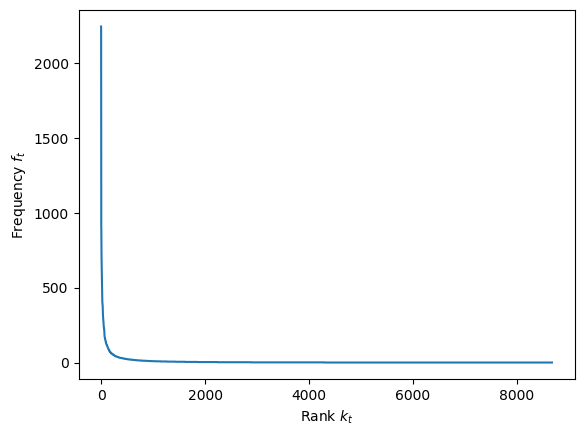

In [6]:
plt.plot(tfs['k'], tfs['f'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Frequency $f_t$')
plt.show()

Transform X and Y to log-log coordinates: 

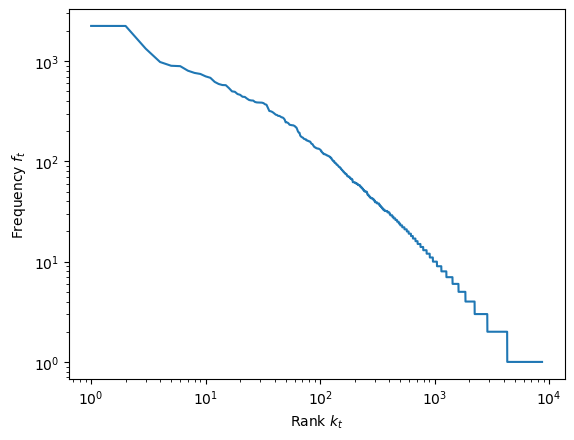

In [7]:
plt.loglog(tfs['k'], tfs['f'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Frequency $f_t$')
plt.show()

Now each term's probability to occur can be estimated by:

$$ p_t = \frac{f_t}{\sum_t f_t} $$

In [8]:
ttf = tfs['f'].sum()
tfs['p'] = tfs['f'] / ttf
tfs[['t','k','p']].head()

t  k         p
0   to  1  0.027971
1  you  2  0.027946
2  the  3  0.016568
3  and  4  0.012214
4   in  5  0.011203

Plot probability $p_t$ vs. rank $k_t$: 

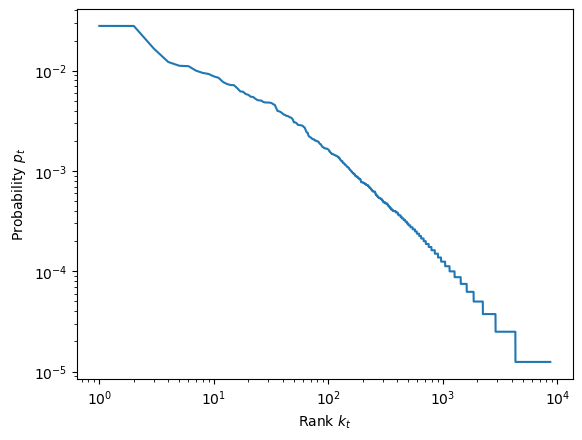

In [9]:
plt.loglog(tfs['k'], tfs['p'])
plt.xlabel('Rank $k_t$')
plt.ylabel('Probability $p_t$')
plt.show()

Does it look like a straight line on log-log coordinates? Does it follow the Zipf's law? 

Let's perform a linear regression on the log-transformed $p_t$ and $k_t$: 

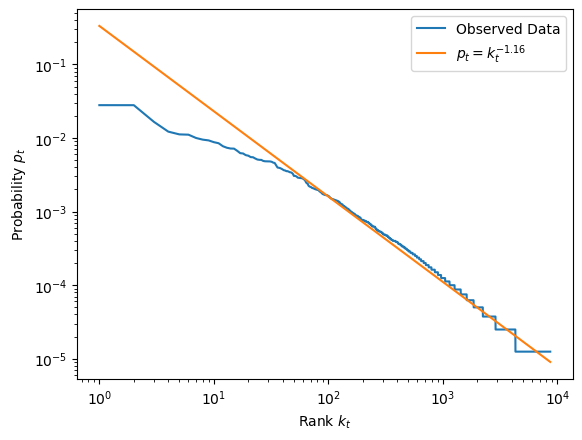

In [10]:
from sklearn.linear_model import LinearRegression

# log transformation of k and p values
x = tfs['k'].values.reshape(-1,1)
xlog = np.log(x)
y = tfs['p'].values.reshape(-1,1)
ylog = np.log(y)

# perform linear regression on log values
lm = LinearRegression()
lm.fit(xlog,ylog)
yplog = lm.predict(xlog)

# plot the fitted (predicted) line 
# along with actual k_t and p_t data
plt.loglog(tfs['k'], tfs['p'], label="Observed Data")
plt.loglog(x, np.exp(yplog), 
           label="$p_t = k_t^{" + "{:.2f}".format(lm.coef_[0][0]) + "}$")
plt.xlabel('Rank $k_t$')
plt.ylabel('Probability $p_t$')
plt.legend()
plt.show()

So the fitted line is roughly: 

\begin{eqnarray} 
    p_t & = & k_t^{-1.16} \\
    & = & \frac{1}{k_t^{1.16}}
\end{eqnarray}

Not exactly $p_t = \frac{1}{k_t}$ as the Zipf's law suggests. 

### A.3. Probabilities in Training Data

Given the above dataset, let's split it into two random subsets: 80% training and 20% testing.

In [11]:
# generate random true (80% chance) or false values
train_index = np.random.rand(len(emails)) < 0.8
# use the above list to take the training (true values)
train = emails[train_index]
# the opposite (rest) is for testing
test = emails[~train_index]

The probability of a ham $p(ham)$ in the training data: 

In [12]:
# get the total number of instances
n = train.shape[0]
# get the total number of hams
counts = train.groupby("v1")["v1"].value_counts()
ham = counts[0]
# compute probability
p_ham = ham / n
print("p(ham) = {:.3f}".format(p_ham))

p(ham) = 0.862


The probability of a spam $p(spam)$: 

In [13]:
# get the total number of spams
spam = counts[1]
# compute probability
p_spam = spam / n
print("p(spam) = {:.3f}".format(p_spam))

p(spam) = 0.138


Now we vectorize the training data: 

In [14]:
vect = CountVectorizer(analyzer="word")
X_train = vect.fit_transform(train.v2)

And use the trained dictionary to vectorize test data: 

In [15]:
X_test = vect.transform(test.v2)

We split the training data into spam and ham subsets: 

In [16]:
ham_index = train['v1']=='ham'
hams = train[ham_index]
spams = train[~ham_index]
X_hams = vect.transform(hams.v2)
X_spams = vect.transform(spams.v2)
X_hams.shape

(3851, 7748)

Let's locate a term in the list of terms (dictionary): 

In [17]:
terms = vect.get_feature_names()
t = "prize"
i = terms.index(t)
print("The {:d}th term is: {:s}".format(i, t))

The 5427th term is: prize


We can compute conditional probabibility of a term in the ham $p(t|ham)$: 

In [18]:
hamf = X_hams.toarray().sum(axis=0)
hamttf = hamf.sum()
f = hamf[i]
p = f / hamttf
ps = (f+1)/(hamttf+2)
print("p({:s}|ham) = {:.7f}, smoothed to {:.7f}".format(t, p, ps))

p(prize|ham) = 0.0000000, smoothed to 0.0000199


You see it is very unlikely for term ```prize``` to appear in a ham (normal email). 

Now let's look at the conditional probability of the same term in the spam $p(t|spam)$: 

In [19]:
terms = vect.get_feature_names()
spamf = X_spams.toarray().sum(axis=0)
spamttf = spamf.sum()
f = spamf[i]
p = f / hamttf
ps = (f+1)/(spamttf+2)
print("p({:s}|spam) = {:.7f}, smoothed to {:.7f}".format(t, p, ps))

p(prize|spam) = 0.0015346, smoothed to 0.0054257


What do $p(prize|ham)$ and $p(prize|spam)$ mean respectively? 

Apparently, it is much more likely to see ```prize``` in a spam than in a ham, i.e. $p(prize|ham) \gg p(prize|spam)$.

Take a look at a few other terms (words) in spam vs. ham to see if their conditional probabilities make sense. 

In [40]:
t1 = terms.index("prize")
t2 = terms.index("meeting")
t1, t2

(5427, 4429)

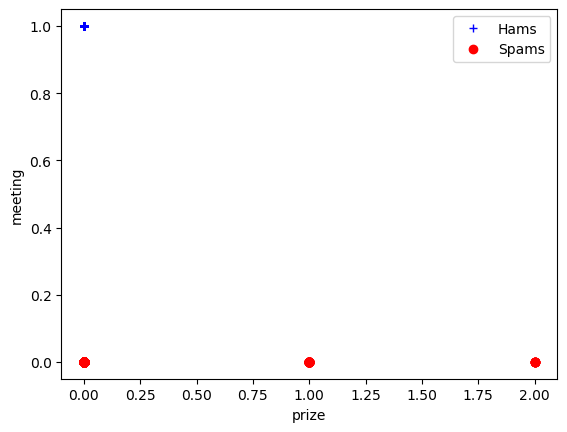

In [46]:
# Example to plot two term (column vectors) on x and y
plt.plot(X_hams.toarray()[:,t1], X_hams.toarray()[:,t2], '+', color="blue", label="Hams")
plt.plot(X_spams.toarray()[:,t1], X_spams.toarray()[:,t2], 'o', color="red", label="Spams")
plt.xlabel("prize")
plt.ylabel("meeting")
plt.legend()

### A.4. Probabilistic Binary Model (Bernoulli Naive Bayes)

The above probabilities form the basis of the Naive Bayes model (probabilistic classification). 

Now let's train a Bernoulli Naive Bayes classifier, with binary term occurrences: 

In [138]:
from sklearn.naive_bayes import BernoulliNB

# build the Bernoulli Naive Bayes classifiers
# with parameters, such as: 
# 1. alpha value for the Laplace estimator (smoothing)
# 2. binarize, the threshold/cutoff for 0 or 1 values
bNB = BernoulliNB(alpha=.01, binarize=0.0)
bNB.fit(X_train, train.v1)
v1p = bNB.predict(X_test)

In [139]:
print(v1p)

['spam' 'ham' 'ham' ... 'ham' 'ham' 'spam']


Now let's compare and compute predicted values $v1p$ and actual class labels $v1$ in the testing data. We first look at the confusion matrix: 

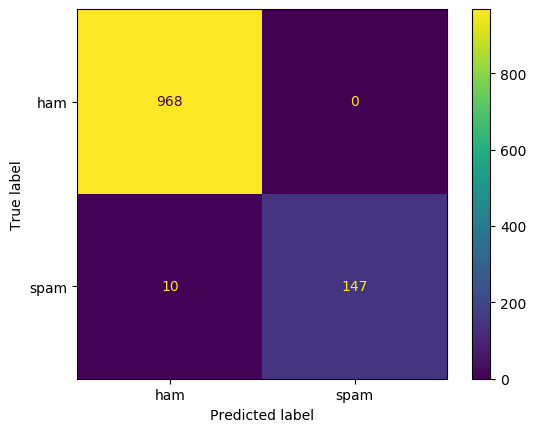

In [149]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(v1p, test.v1)
display(plot_confusion_matrix(bNB, X_test, test.v1, values_format='d'))

Look at the confusion matrix here and think about these questions: 
+ Among the four values, which one would you like to maximize for spam filtering? 
+ Which ones would you minimize? 

In [141]:
from sklearn.metrics import accuracy_score, cohen_kappa_score 
acc = accuracy_score(v1p, test.v1)
kappa = cohen_kappa_score(v1p, test.v1)

print("Accuracy: {:.4f}".format(acc))
print("Kappa   : {:.4f}".format(kappa))

Accuracy: 0.9911
Kappa   : 0.9620


Adjust the parameters, train and test the data again. Does it make any difference? 

### A.5. Probablistic Term Frequency Model (Multinomial Naive Bayes)

Likewise, we can train and test the Naive Bayes model with the Multinomial distribution (term frequencies). 

In [146]:
from sklearn.naive_bayes import MultinomialNB

# build the Bernoulli Naive Bayes classifiers
# with parameters, such as: 
# 1. alpha value for the Laplace estimator (smoothing)
mNB = MultinomialNB(alpha=1)
mNB.fit(X_train, train.v1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

Take a look at some of the probabilities: 

In [147]:
import math

pt_ham = mNB.feature_log_prob_[0][i]
pt_spam = mNB.feature_log_prob_[1][i]
print('p({:s}|ham) = {:.7f}'.format(t, math.exp(pt_ham)))
print('p({:s}|spam) = {:.7f}'.format(t, math.exp(pt_spam)))

p(prize|ham) = 0.0000173
p(prize|spam) = 0.0032477


Compare the estimated values to the same conditional probabilities we obtained earlier. Are they similar, relatively? 

Now let's use the trained model (estimated probabilities) to predit on the test data: 

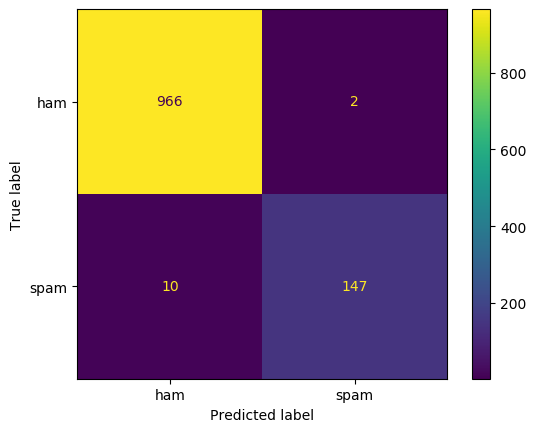

In [150]:
v1p = mNB.predict(X_test)
print()
display(plot_confusion_matrix(mNB, X_test, test.v1, values_format='d'))

Evaluation with related metrics: 

In [145]:
acc = accuracy_score(v1p, test.v1)
kappa = cohen_kappa_score(v1p, test.v1)

print("Accuracy: {:.4f}".format(acc))
print("Kappa   : {:.4f}".format(kappa))

Accuracy: 0.9884
Kappa   : 0.9515


Again, you may play with the alpha parameter (Laplace smoothing) for the model. What model performs better? 

Are accuracy and kappa good metrics for the evaluation here? Think about what your objective is for email spam filtering and what your objectives might be? Are there any other evaluation metrics -- precision, recall, specificity, etc. -- that you should consider here? 

## B. Linear Classification Model

Here is a small dataset about car evaluation: [cars.txt](data/cars.txt). It is originally from UCI's Car Evaluation Data Set (https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) and has been modified (**idealized** for now) for demonstration here. 

We focus on each car's:
1. **Buying price** $b$
2. **Maintenance cost** $m$
3. **Car evaluation**, i.e. class $a$ with values of accceptable ($1$) or unacceptable $0$. 

In [428]:
cars = pd.read_csv("data/cars.txt", sep=" ")
display(cars[['b','m','a']].sample(frac=0.5))

b  m  a
7   3  1  0
6   3  2  0
11  1  3  0
3   4  1  0
12  2  1  1
0   4  4  0
9   2  3  0
5   3  3  0

Now take a look at the car's evaluation $a$ (acceptable vs. unacceptable) on the two attribute dimensions, buying price $b$ and maintenance cost $m$: 

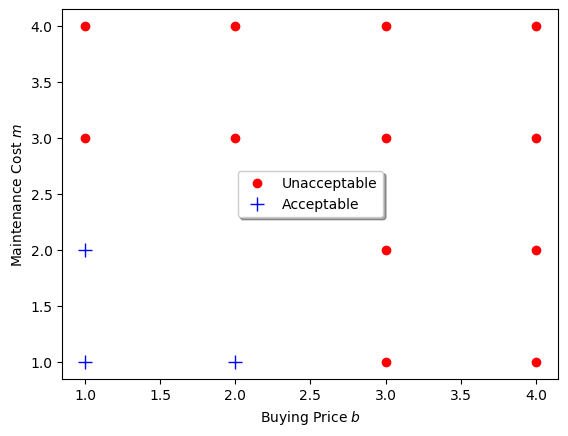

In [429]:
positive = cars['a']>0
cars0 = cars[~positive]
cars1 = cars[positive]
# for name, group in groups: 
plt.plot(cars0.b, cars0.m, linestyle='', marker='o', 
         color="red", ms=6, label="Unacceptable")
plt.plot(cars1.b, cars1.m, linestyle='', marker='+', 
         color="blue", ms=10, label="Acceptable")
plt.xlabel("Buying Price $b$")
plt.ylabel("Maintenance Cost $m$")
plt.legend(loc="center", shadow=True)
plt.show()

### B.1. Linear Classification (Perceptron) with Idealized Data

Let's use the cars data to train a perceptron: 

In [457]:
from sklearn.linear_model import Perceptron

# build a perceptron (single layer neural network)
# with parameters: 
# 1. 20 iterations
# 2. learning rate of 0.15
net1 = Perceptron(max_iter=20, eta0=0.15, random_state=0)
net1.fit(cars[['b','m']], cars['a'])
w0 = net1.intercept_[0]
w1, w2 = net1.coef_[0]
print("The linear model is: {:.2f}{:+.2f}b{:+.2f}m = 0".format(w0, w1, w2))

The linear model is: 1.05-0.30b-0.30m = 0


Now we can visualize the linear function, a line on the 2-dimensional space: 

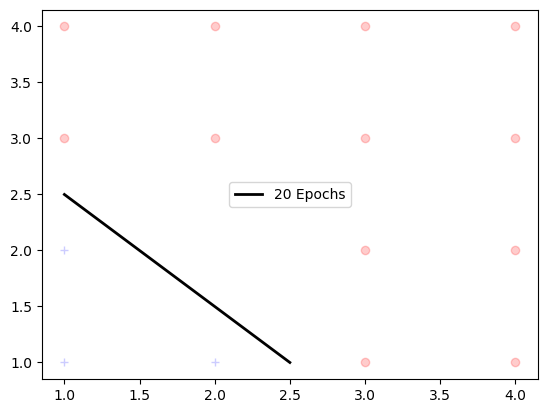

In [458]:
# function to plot data with linear model
def plot_linear(ax, title, cars0, cars1):
    global w0, w1, w2
    ax.plot(cars0.b, cars0.m, linestyle='', marker='o', 
             color="red", alpha=0.2)
    ax.plot(cars1.b, cars1.m, linestyle='', marker='+', 
             color="blue", alpha=0.2)
    x = np.array([1, 2.5])
    y = -(w0 + w1 * x)/w2
    ax.plot(x, y, color="black", linewidth=2, label=title)
    ax.legend(loc="center")

positive = cars['a']>0
cars0 = cars[~positive]
cars1 = cars[positive]
plot_linear(plt, "20 Epochs", cars0, cars1)
plt.show()

Now that the Perceptron takes 20 iterations to find the weight, let's go through the iterations to see how the values of $[w_0, w_1, w_2]$ are updated and converge. 

In [468]:
import warnings

it, w0s, w1s, w2s = [], [], [], []
for i in range(1,16):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        net1 = Perceptron(max_iter=i, eta0=0.15, random_state=0) #, warm_start=True)
        net1.fit(cars[['b','m']], cars['a'])
    it.append(i)
    w0s.append(net1.intercept_[0])
    w1s.append(net1.coef_[0][0]) # / (net1.intercept_[0] + 0.000000001))
    w2s.append(net1.coef_[0][1]) # / (net1.intercept_[0] + 0.000000001))
    

Now we can plot how the $w$ values change over the iterations (epochs): 

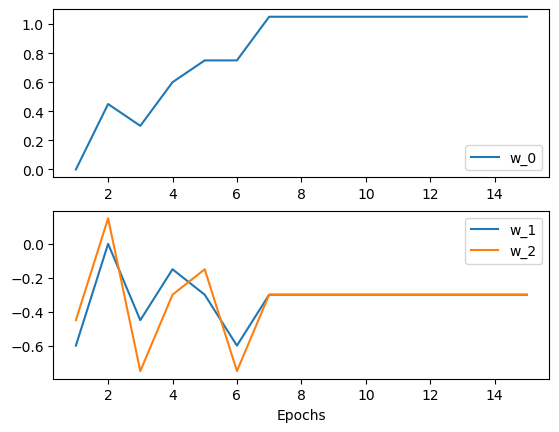

In [469]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(it, w0s, label="w_0")
ax1.legend(loc="lower right")
ax2.plot(it, w1s, label="w_1")
ax2.plot(it, w2s, label="w_2")
ax2.set(xlabel="Epochs")
# ax1.ylabel("Values")
ax2.legend()
# fig.show()
plt.show()

Here is the visualized evolution of the linear function (straight line) over the iterations (epochs): 

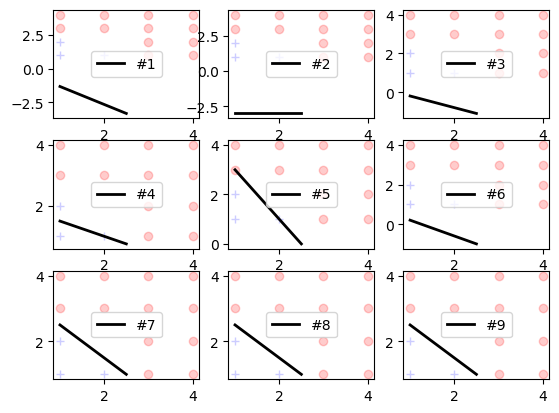

In [461]:
fig, axs2 = plt.subplots(3,3) 
i=0
for axs in axs2:
    for ax in axs: 
        ep = it[i]
        w0 = w0s[i]
        w1 = w1s[i]
        w2 = w2s[i]
        plot_linear(ax, "#{0}".format(ep), cars0, cars1)
        i += 1

### B.2. Linear Classification with Not-So-Ideal Data

Now if we simply add a **new data** point $(2,2,1)$ to the idealized data: 

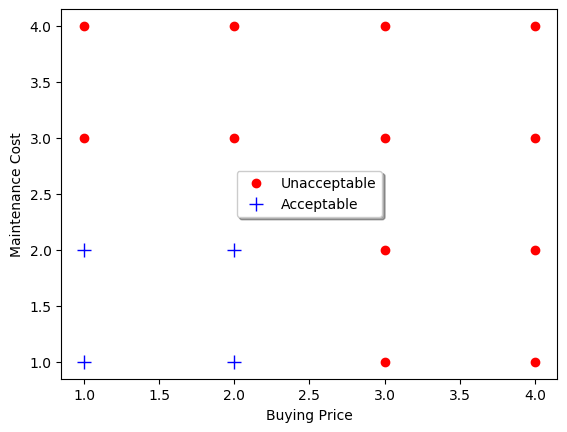

In [225]:
new = pd.DataFrame([[2,2,1]], columns=['b','m','a'])
newcars = cars.append(new)

positive = newcars['a']>0
newcars0 = newcars[~positive]
newcars1 = newcars[positive]
# for name, group in groups: 
plt.plot(newcars0.b, newcars0.m, linestyle='', marker='o', 
         color="red", ms=6, label="Unacceptable")
plt.plot(newcars1.b, newcars1.m, linestyle='', marker='+', 
         color="blue", ms=10, label="Acceptable")
plt.xlabel("Buying Price")
plt.ylabel("Maintenance Cost")
plt.legend(loc="center", shadow=True)
plt.show()

Now our training data in ```newcars``` have a **new situation** not encountered before. 

Let's repeat the process: 
1. Train and visualize the Perceptron model on the ```newcars``` data (as we did on the ```cars``` data earlier). 
2. Do you think we will obtain a good linear function (perceptron)? 

In [233]:
net1 = Perceptron(max_iter=100, eta0=0.15, random_state=0)
net1.fit(newcars[['b','m']], newcars['a'])
w0 = net1.intercept_[0]
w1, w2 = net1.coef_[0]
print("The linear model is: {:.2f}{:+.2f}b{:+.2f}m = 0".format(w0, w1, w2))

The linear model is: 1.65-0.45b-0.75m = 0


Here is the model after 100 iterations (epochs):

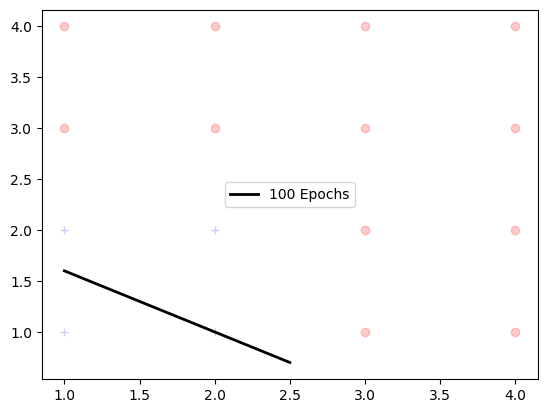

In [234]:
plot_linear(plt, "100 Epochs", newcars0, newcars1)

Even after many iterations (epochs) of training, the linear function cannot seem to separate the two classes. 

The $w$ coefficients did converged but the results here are not as sastifactory. 

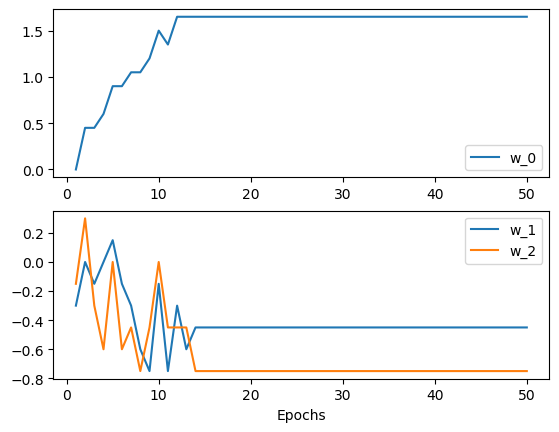

In [238]:
it, w0s, w1s, w2s = [], [], [], []
for i in range(1,51):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        net1 = Perceptron(max_iter=i, eta0=0.15, random_state=0) #, warm_start=True)
        net1.fit(newcars[['b','m']], newcars['a'])
    it.append(i)
    w0s.append(net1.intercept_[0])
    w1s.append(net1.coef_[0][0])
    w2s.append(net1.coef_[0][1])

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(it, w0s, label="w_0")
ax1.legend(loc="lower right")
ax2.plot(it, w1s, label="w_1")
ax2.plot(it, w2s, label="w_2")
ax2.set(xlabel="Epochs")
# ax1.ylabel("Values")
ax2.legend()
# fig.show()
plt.show()

## C. Non-Linear Model with Multi-layer Neural Network

Now that the data cannot be linear separated, let's try a Multi-layer Neural Network (non-linear classifier) on the data: 

In [391]:
from sklearn.neural_network import MLPClassifier
net2 = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', 
                     solver='lbfgs', max_iter=100)
net2.fit(newcars[['b','m']], newcars['a'])
net2.predict(newcars[['b','m']])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

To better understand the model, let's use the notation here according to  the [Non-Linear Classification Model](../models/nonlinear_class.html) lecture:

<img src="../models/figures/nn_sigmoid.png" style="width:500px;" alt="Neural Network">

Note: A difference in ```MLPClassifier``` we built here is the **additional links** from $v_1 \to h_2$ and $v_2 \to h_1$ -- the above lecture/figure skips those links to simplify the calculation and it still works. 

$v$ variables for the input: 
+ $v_1$: the buying price variable ```b```
+ $v_2$: the maintenance cost variable ```m```

$h$ variables for the hidden layer (only one layer): 
+ $h_0 = f(1)$: is the hidden layer for overall bias input. 
+ $h_1 = f(s_1)$: is activation based on the weighted sum $s_1$ to hidden node $1$. 
+ $h_2 = f(s_2)$: is activation based on the weighted sum $s_2$ to hidden node $2$. 

where $f$ is the sigmoid (logistic) function for activation: 

$$ f(s) = \frac{1}{1 + e^{-s}}$$

Based on the coefficients obtained from the above model, we have: 
+ From bias $v_0$ to hidden layer: 

In [413]:
print(net2.intercepts_[0])

[-12.57121706  -9.68794063]


+ From $v_1$ to hidden layer, i.e. first layer (index $0$) and first variable (index $0$): 

In [414]:
print(net2.coefs_[0][0])

[0.73041739 4.79190664]


+ From $v_2$ to hidden layer, i.e. first layer (index $0$) and second variable (index $1$): 

In [415]:
print(net2.coefs_[0][1])

[ 4.59219876 -1.76613761]


Following the model, we define a general function for the sum: 

In [416]:
import math
# weight sum of input layer to a hidden node
# v1 and v2 are input values
# i is the index of the layer (0 from input to hidden, 1 from hidden to output)
# j is the index of the node to receive the sum
def s(v1, v2, i, j): 
    w0 = net2.intercepts_[i][j]
    w1 = net2.coefs_[i][0][j]
    w2 = net2.coefs_[i][1][j]
    return w0 + w1*v1 + w2*v2

def sigmoid(s):
    return 1 / (1 + math.exp(-s))

Hence, given input values such as $(v_1=2, v_2=2)$, the hidden nodes receive the following weighted sums: 

In [441]:
s1 = s(2,2,0,0)
s2 = s(2,2,0,1)
print("Weighted sum to hidden node 1: s1 = {:.2f}".format(s1))
print("Weighted sum to hidden node 2: s2 = {:.2f}".format(s2))

Weighted sum to hidden node 1: s1 = -1.93
Weighted sum to hidden node 2: s2 = -3.64


Using the sigmoid function, the hidden layer activated values are:

In [434]:
h1 = sigmoid(s1)
h2 = sigmoid(s2)
print("Sigmoid activation of hidden node 1: h1 = {:.2f}".format(h1))
print("Sigmoid activation of hidden node 2: h2 = {:.2f}".format(h2))

Sigmoid activation of hidden node 1: h1 = 0.13
Sigmoid activation of hidden node 2: h2 = 0.03


Now if we apply this process to all instances in the ```newcars``` data:

In [436]:
# compute the hidden layer output
# weighted sum
newcars['s1'] = s(newcars['b'], newcars['m'], 0, 0)
newcars['s2'] = s(newcars['b'], newcars['m'], 0, 1)
# sigmoid transformation
newcars['h1'] = 1/(1 + np.exp(- newcars['s1'])) 
newcars['h2'] = 1/(1 + np.exp(- newcars['s2'])) 

# compute the final output
# weighted sum and then sigmoid transformation
newcars['so'] = s(newcars['h1'], newcars['h2'], 1, 0)
newcars['o'] = 1/(1 + np.exp(- newcars['so']))

And we can plot the hidden layer result $h_1$ and $h_2$, which is a non-linear transformation of $v_1$ and $v_2$ using a sigmoid (logistic) function. You can see here that the data are now linearly separable: 

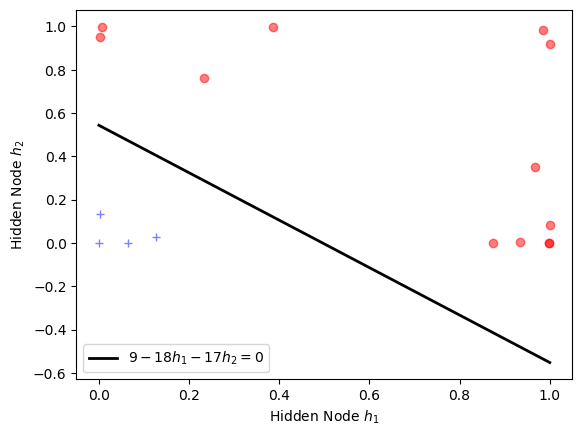

In [449]:
positive = newcars['a']>0
newcars0 = newcars[~positive]
newcars1 = newcars[positive]
# for name, group in groups: 
plt.plot(newcars0.h1, newcars0.h2, linestyle='', marker='o', 
         color="red", alpha=0.5)
plt.plot(newcars1.h1, newcars1.h2, linestyle='', marker='+', 
         color="blue", alpha=0.5)
plt.xlabel("Hidden Node $h_1$")
plt.ylabel("Hidden Node $h_2$")
x = np.array([0, 1])

w0 = net2.intercepts_[1][0]
w1 = net2.coefs_[1][0][0]
w2 = net2.coefs_[1][1][0]
y = -w0/w2 - w1 * x / w2

equation = "${:.0f}{:+.0f}h_1{:+.0f} h_2 = 0$".format(w0, w1, w2)

plt.plot(x, y, color="black", linewidth=2, label=equation)
plt.legend()
plt.show()

The solid line here is in fact the linear function obtained by the Multi-layer Perceptron at the output layer where: 

$$ \sum_i w_i h_i = 0$$

With the three $w$ weights estimated here: 

In [451]:
print("Weights (w0, w1, w2) at the output: ({:.0f}, {:.0f}, {:.0f})".format(w0, w1, w2))

Weights (w0, w1, w2) at the output: (9, -18, -17)


The final linear equation at the output can be written as: 

\begin{eqnarray}
\sum_i w_i h_i & = & 9 - 18 h_1 - 17 h_2 \\
               & = & 0
\end{eqnarray}

which is the solid line in the above plot. 

You see the multi-layer perceptron is essentially transforming data with non-linear functions (e.g. a sigmoid) -- sometimes multiple transformations through multiple hidden layers -- and, in the end, use a linear equation (weighted sum) to separate the transformed data. 

## D. Further Research and Exercise


In this exercise, we discuss multiple classification models and datasets. 

Here are models that we have trained and/or tested: 

|  Model               | Spam Data (Text) | Idealized Cars (linear) | Cars (non-linear) |
|----------------------|:----------------:|:-----------------------:|:-----------------:|
| Bernoulli NB (prob)  | [x]              |                         |                   |
| Multinomial NB (prob)| [x]              |                         |                   |
| Single Perceptron    |                  |  [x]                    | [x] Not fit       |
| ML Perceptron (NN)   |                  |                         | [x]               |

Please consider some additional tasks: 
1. Apply the probabilistic models to the cars data. 
2. Apply the Perceptron -- single or multi-layer -- to the spam (text) data. 
3. Evaluate and compare their performances. 

You may also consider some other classification models available in **scikit learn**: 
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm

For example: 
+ Support Vector Machines (SVM): ```sklearn.svm.LInearSVC```, ```sklearn.svm.SVC```
+ Decision Tree: ```sklearn.tree.DecisionTreeClassifier```
+ Lazy Learning: ```sklearn.neighbors.KNeighborsClassifier```